In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from sklearn.preprocessing import normalize
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
#Read data
training_variants = pd.read_csv('training_variants')
training_text = pd.read_csv('training_text', sep = '\|\|', engine = 'python', names = ['ID', 'Text'], skiprows = 1)

In [4]:
print('number of data points: ', training_variants.shape[0])
print('number of feautures: ', training_variants.shape[1])
training_variants.head()


number of data points:  3321
number of feautures:  4


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
print('number of data points: ', training_text.shape[0])
print('number of feautures: ', training_text.shape[1])
training_text.head()

number of data points:  3321
number of feautures:  2


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
training_text['Text'].isnull().sum()

5

In [7]:
stop_words = stopwords.words('English')

def preprocessing_text(text):
    #replace special chars with space
    final = ''
    text = text.lower()
    text = re.sub('[^a-z0-9\n]', ' ', text)
    text = re.sub('\s+', ' ', text)
    for word in text.split():
        if word not in stop_words:
            final += word + ' '
    return final

In [8]:
for idx, row in training_text.iterrows():
    if type(row['Text']) is str:
        training_text['Text'][idx] = preprocessing_text(row['Text'])
        
        

c:\users\srini\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
training_text.head()

,ID,Text
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


In [10]:
# merge two tables into one based on Id and dropping rows where text is null

data = pd.merge(training_variants, training_text, on = 'ID', how = 'left')
data.dropna(inplace = True)
data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


# Split data into train, CV and test

In [11]:
y_true = data['Class']
data.Gene = data.Gene.replace('\s+', '_')
data.Variation = data.Variation.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, Y_train, Y_test = train_test_split(data, y_true, stratify = y_true, test_size = 0.2)

# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, stratify = Y_train, test_size = 0.2)

In [12]:
print('No of data points in train, test, CV respectively are', X_train.shape[0], X_test.shape[0], X_cv.shape[0])
X_train.to_csv('X_train')
X_test.to_csv('X_test')
X_cv.to_csv('X_cv')
Y_train.to_csv('Y_train')
Y_test.to_csv('Y_test')
Y_cv.to_csv('Y_cv')


No of data points in train, test, CV respectively are 2121 664 531


In [31]:
X_train = pd.read_csv('X_train')
X_test = pd.read_csv('X_test')
X_cv = pd.read_csv('X_cv')
Y_train = pd.read_csv('Y_train', header = None)
Y_test = pd.read_csv('Y_test', header = None)
Y_cv = pd.read_csv('Y_cv', header = None)
X_train.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)
X_test.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)
X_cv.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)
Y_train.drop(columns = 0, axis = 1,  inplace = True)
Y_test.drop(columns = 0, axis = 1,  inplace = True)
Y_cv.drop(columns = 0, axis = 1,  inplace = True)


In [32]:
X_train.head()

,ID,Gene,Variation,Class,Text
0,2113,SRC,Amplification,2,non receptor tyrosine kinase c src hereafter r...
1,503,TP53,F212Y,6,tumor suppressor p53 dependent apoptosis thoug...
2,2722,BRAF,S151A,2,melanocytes use braf activate map kinase mapk ...
3,2740,BRAF,L584F,6,nras braf genes frequently mutated melanoma su...
4,2430,BRCA1,L63F,6,germline mutations breast cancer 1 brca1 gene ...


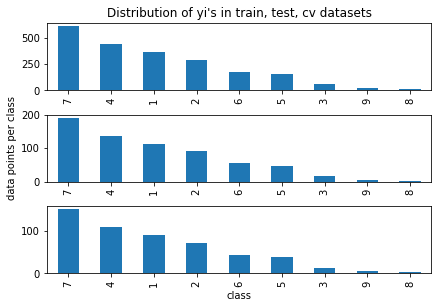

In [33]:
train_cls_distribution = X_train['Class'].value_counts()
test_cls_distribution = X_test['Class'].value_counts()
cv_cls_distribution = X_cv['Class'].value_counts()

plt.subplot(3,1,1)
train_cls_distribution.plot(kind = 'bar')
plt.title('Distribution of yi\'s in train, test, cv datasets')
plt.tight_layout()
plt.subplot(3,1,2)
test_cls_distribution.plot(kind = 'bar')
plt.ylabel('data points per class')
plt.subplot(3,1,3)
cv_cls_distribution.plot(kind = 'bar')
plt.xlabel('class')


plt.show()


#from the graph below, it can be understood that the distribution of yi's is almost same among train, test and cv
# Also each dataset is imbalanced


In [34]:
train_cls_distribution

7    609
4    439
1    362
2    289
6    174
5    155
3     57
9     24
8     12
Name: Class, dtype: int64

In [35]:
X_test.head()

,ID,Gene,Variation,Class,Text
0,553,SMAD3,Y298A,1,hub proteins connected binding interactions ma...
1,3218,NTRK1,Fusions,2,identified novel gene fusions patients lung ca...
2,3169,RAF1,S427G,7,mutations leading activation raf mitogen activ...
3,1395,FGFR3,D617G,1,frequent genetic alterations discovered fgfrs ...
4,1069,ACVR1,G328E,2,diffuse intrinsic pontine glioma dipg fatal br...


# Univariate analysis
. Gene, What type of feature it is ?

Ans. Gene is a categorical variable

Q2. How many categories are there and How they are distributed?

In [36]:
unique_gene = X_train['Gene'].value_counts()

In [37]:
print('Number of unique genes', unique_gene.shape[0])
unique_gene.head()

Number of unique genes 233


BRCA1    174
TP53     105
EGFR     101
PTEN      80
BRCA2     73
Name: Gene, dtype: int64

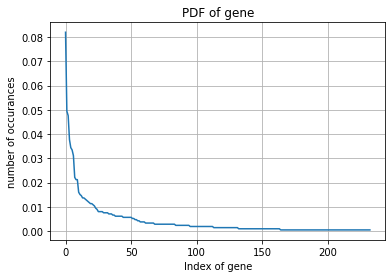

In [38]:
total = sum(unique_gene.values)
freq = unique_gene.values/total
plt.plot(freq)
plt.grid()
plt.xlabel('Index of gene')
plt.ylabel('number of occurances')
plt.title('PDF of gene')
plt.show()

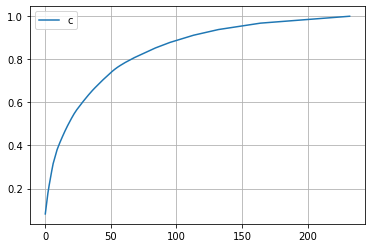

In [39]:
cumsum = np.cumsum(freq)
plt.plot(cumsum)
plt.grid()
plt.legend('cummulative distribution of genes')
plt.show()

Q3. How to featurize this Gene feature ?

One hot Encoding 
Response coding 
We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests.

In [40]:
#response coding

def get_feature_dict_prob_class(alpha, feature):
    value_counts = X_train[feature].value_counts()
    feature_dict = dict()
    for i, denominator in value_counts.items():
        vec = []
        for c in range(1,10):
            class_cnt = X_train.loc[(X_train[feature] == i) & (X_train['Class'] ==  c)]
            vec.append((class_cnt.shape[0] + 10*alpha)/(denominator + 90*alpha))
        feature_dict[i] = vec
        
    return feature_dict
        
        

In [41]:
def get_feature(alpha, feature, df):
    feature_dict = get_feature_dict_prob_class(alpha, feature)
    features = []
    for i, row in df.iterrows():
        if row[feature] in feature_dict:
            features.append(feature_dict[row[feature]])
        else:
            features.append([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
    return np.array(features)

In [42]:
alpha = 1
train_gene_response_coding = get_feature(alpha, 'Gene', X_train)
cv_gene_response_coding = get_feature(alpha, 'Gene', X_cv)
test_gene_response_coding = get_feature(alpha, 'Gene', X_test)

In [43]:
#one hot encoding

gene_vectorizer = CountVectorizer()
train_gene_onehot = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_onehot = gene_vectorizer.transform(X_test['Gene'])
cv_gene_onehot = gene_vectorizer.transform(X_cv['Gene'])

In [44]:
train_gene_onehot


<2121x232 sparse matrix of type '<class 'numpy.int64'>'
	with 2121 stored elements in Compressed Sparse Row format>

In [50]:
Y_test = Y_test[1:]
Y_cv = Y_cv[1:]
Y_train = Y_train[1:]

# Q4. How good is this gene feature in predicting y_i?


There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

In [51]:
#predict using gene feature. Logistic regression

alpha = [10**x for x in range(-5, 1)]
cv_error = []
for i in alpha:
    clf = SGDClassifier(alpha = i, loss = 'log', penalty = 'l2', random_state = 50)
    clf.fit(train_gene_onehot, Y_train.values.ravel())
    
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_gene_onehot, Y_train.values.ravel())
    predict_y = sig_clf.predict_proba(cv_gene_onehot)
    
    cv_error.append(log_loss(Y_cv, predict_y, labels = clf.classes_, eps = 1e-15))
    print('log loss with alpha = ', i, 'is ', cv_error[-1])
    

log loss with alpha =  1e-05 is  1.1777536252353473
log loss with alpha =  0.0001 is  1.1554666719324775
log loss with alpha =  0.001 is  1.2057495740689002
log loss with alpha =  0.01 is  1.3463464813574912
log loss with alpha =  0.1 is  1.45436553286588
log loss with alpha =  1 is  1.490605728876996


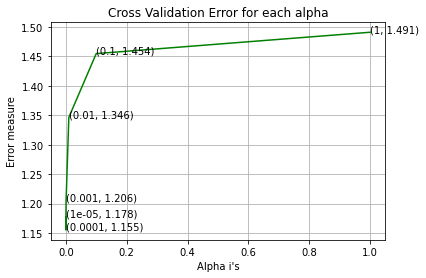

In [52]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_error,c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


In [53]:
best_alpha = np.argmin(cv_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_onehot, Y_train.values.ravel())
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_onehot, Y_train.values.ravel())

predict_y = sig_clf.predict_proba(train_gene_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))



For values of best alpha =  0.0001 The train log loss is: 0.9915241116991826
For values of best alpha =  0.0001 The cross validation log loss is: 1.1560650014859746
For values of best alpha =  0.0001 The test log loss is: 1.1987696787521558


Q5. Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error.

In [54]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_gene.shape[0], " genes in train dataset?")
train_gene_in_test = X_test[X_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
train_gene_in_cv = X_cv[X_cv['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
print('Ans\n1. In test data',train_gene_in_test, 'out of',X_test.shape[0], ":",(train_gene_in_test/X_test.shape[0])*100)
print('Ans\n1. In test data',train_gene_in_cv, 'out of',X_cv.shape[0], ":",(train_gene_in_cv/X_cv.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  233  genes in train dataset?
Ans
1. In test data 639 out of 664 : 96.23493975903614
Ans
1. In test data 513 out of 531 : 96.61016949152543


# Univariate Analysis on Variation Feature¶

Q7. Variation, What type of feature is it ?

Ans. Variation is a categorical variable

Q8. How many categories are there?

In [55]:
unique_variations = X_train['Variation'].value_counts()
print('Number of unique variations', unique_variations.shape[0])


Number of unique variations 1930


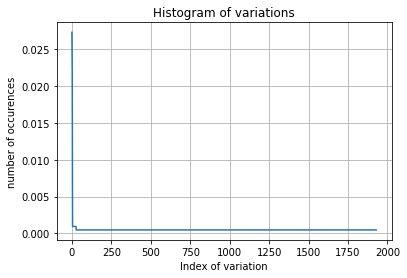

In [56]:
s = sum(unique_variations.values)
h = unique_variations.values/s
plt.grid()
plt.plot(h)
plt.title('Histogram of variations')
plt.xlabel('Index of variation')
plt.ylabel('number of occurences')
plt.show()


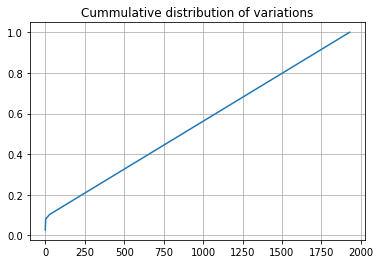

In [57]:
c = np.cumsum(h)
plt.plot(c)
plt.title('Cummulative distribution of variations')
plt.grid()
plt.show()

Q9. How to featurize this Variation feature ?

Ans.
One hot Encoding
Response coding
We will be using both these methods to featurize the Variation Feature

In [58]:
alpha = 1
train_variation_response_coding = get_feature(alpha, 'Variation', X_train)
cv_variation_response_coding = get_feature(alpha, 'Variation', X_cv)
test_variation_response_coding = get_feature(alpha, 'Variation', X_test)

In [59]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_response_coding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2121, 9)


In [60]:
#one hot encoding

variation_vectorizer = CountVectorizer()
train_variation_onehot = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_onehot = variation_vectorizer.transform(X_test['Variation'])
cv_variation_onehot = variation_vectorizer.transform(X_cv['Variation'])

In [61]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_onehot.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2121, 1963)


In [62]:

alpha = [10**x for x in range(-5, 1)]
cv_error = []
for i in alpha:
    clf = SGDClassifier(alpha = i, loss = 'log', penalty = 'l2', random_state = 50)
    clf.fit(train_variation_onehot, Y_train.values.ravel())
    
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_variation_onehot, Y_train.values.ravel())
    predict_y = sig_clf.predict_proba(cv_variation_onehot)
    
    cv_error.append(log_loss(Y_cv, predict_y, labels = clf.classes_, eps = 1e-15))
    print('log loss with alpha = ', i, 'is ', cv_error[-1])

log loss with alpha =  1e-05 is  1.705469322984135
log loss with alpha =  0.0001 is  1.6990434732666213
log loss with alpha =  0.001 is  1.6949104272087172
log loss with alpha =  0.01 is  1.7082102878765828
log loss with alpha =  0.1 is  1.7206115795393053
log loss with alpha =  1 is  1.7207712873913723


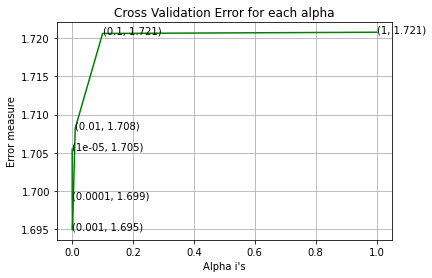

In [63]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_error,c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [64]:
best_alpha = np.argmin(cv_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_onehot, Y_train.values.ravel())
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_onehot, Y_train.values.ravel())

predict_y = sig_clf.predict_proba(train_variation_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))



For values of best alpha =  0.001 The train log loss is: 1.1745271695658872
For values of best alpha =  0.001 The cross validation log loss is: 1.6947575019248646
For values of best alpha =  0.001 The test log loss is: 1.6986344787833692


Q11. Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Not sure! But lets be very sure using the below analysis.

In [65]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
train_var_in_test = X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
train_var_in_cv = X_cv[X_cv['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
print('Ans\n1. In test data',train_var_in_test, 'out of',X_test.shape[0], ":",(train_var_in_test/X_test.shape[0])*100)
print('2. In cross validation data',train_var_in_cv, 'out of ',X_cv.shape[0],":" ,(train_var_in_cv/X_cv.shape[0])*100)

Q12. How many data points are covered by total  1930  genes in test and cross validation data sets?
Ans
1. In test data 70 out of 664 : 10.542168674698797
2. In cross validation data 56 out of  531 : 10.546139359698682


# Univariate Analysis on Text Feature

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [66]:
def extract_dict_words(df):
    dic = defaultdict(int)
    for i, row in df.iterrows():
        for word in row['Text'].split():
            dic[word] += 1
    return dic

In [67]:
#resonse coding of text feature
#https://stackoverflow.com/a/1602964
import math

def text_responsecoding(df):
    text_response = np.zeros((df.shape[0], 9))
    for i in range(9):
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['Text'].split():
                sum_prob += math.log((dict_list[i].get(word,0) + 10)/(total_dict.get(word,0) + 90))
            text_response[index][i] = math.exp(sum_prob/len(row['Text'].split()))
    return text_response

In [68]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = X_train[X_train['Class'] == 1]
    dict_list.append(extract_dict_words(cls_text))
    
total_dict = extract_dict_words(X_train)

In [69]:
train_text_response = text_responsecoding(X_train)
test_text_response = text_responsecoding(X_test)
cv_text_response = text_responsecoding(X_cv)

In [70]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_response = (train_text_response.T/train_text_response.sum(axis = 1)).T
test_text_response = (test_text_response.T/test_text_response.sum(axis = 1)).T
cv_text_response = (cv_text_response.T/cv_text_response.sum(axis = 1)).T

In [71]:
text_vectorizer = CountVectorizer(min_df = 3)
train_text_oneHot = text_vectorizer.fit_transform(X_train['Text'])
train_text_features = text_vectorizer.get_feature_names()
train_text_fea_cnt = train_text_oneHot.sum(axis = 0).A1
text_fea_dict = dict(zip(list(train_text_features), train_text_fea_cnt))

print("Total number of unique words in train data :", len(train_text_features), '\nfeature_dict', text_fea_dict)


Total number of unique words in train data : 52711 
feature_dict {'00': 2415, '000': 5604, '0000': 11, '0000001': 6, '000001': 19, '000002': 13, '000003': 3, '000007': 11, '000009': 3, '00001': 18, '000011': 4, '0000112': 3, '000012': 4, '0000208': 6, '00002644': 3, '00005': 10, '000059': 5, '00006': 3, '0000614': 6, '0000645': 3, '00006559': 3, '000077': 80, '00008': 3, '0000839': 3, '00009': 4, '0001': 1464, '0001042': 6, '0001171': 3, '000132': 14, '000141': 7, '000179': 15, '000182': 4, '0001a': 18, '0002': 120, '0002050': 3, '0002079': 3, '0002158': 12, '000245': 13, '000249': 15, '00025': 4, '000251': 16, '000258': 15, '000267': 32, '00029': 5, '0003': 89, '0003073': 3, '0003254': 3, '00034': 4, '0003529': 3, '000368': 3, '000369266': 42, '00037': 6, '0004': 63, '0004376': 3, '00047': 3, '0004798': 3, '0004920': 3, '0005': 74, '0005044': 3, '0005159': 3, '0005214': 3, '0005266': 3, '0005309': 3, '000535': 13, '0005355': 3, '000546': 13, '000548': 69, '000588': 15, '0006': 51, '00

In [72]:
train_text_oneHot = normalize(train_text_oneHot, axis=0)
test_text_oneHot = text_vectorizer.transform(X_test['Text'])
test_text_oneHot = normalize(test_text_oneHot, axis=0)
cv_text_oneHot = text_vectorizer.transform(X_cv['Text'])
cv_text_oneHot = normalize(cv_text_oneHot, axis=0)

log loss with alpha =  1e-05 is  1.3007642559679675
log loss with alpha =  0.0001 is  1.1744678633255736
log loss with alpha =  0.001 is  1.171433266407316
log loss with alpha =  0.01 is  1.2605499978769716
log loss with alpha =  0.1 is  1.4188556532121506
log loss with alpha =  1 is  1.6325338330912986


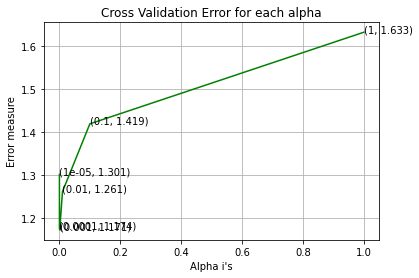

For values of best alpha =  0.001 The train log loss is: 0.6677967629982686
For values of best alpha =  0.001 The cross validation log loss is: 1.1725990236973902
For values of best alpha =  0.001 The test log loss is: 1.1498074834189913


In [73]:
alpha = [10**x for x in range(-5, 1)]
cv_error = []
for i in alpha:
    clf = SGDClassifier(alpha = i, loss = 'log', penalty = 'l2', random_state = 50)
    clf.fit(train_text_oneHot, Y_train.values.ravel())
    
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_text_oneHot, Y_train.values.ravel())
    predict_y = sig_clf.predict_proba(cv_text_oneHot)
    
    cv_error.append(log_loss(Y_cv, predict_y, labels = clf.classes_, eps = 1e-15))
    print('log loss with alpha = ', i, 'is ', cv_error[-1])
    

fig, ax = plt.subplots()
ax.plot(alpha, cv_error,c='g')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_oneHot, Y_train.values.ravel())
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_oneHot, Y_train.values.ravel())

predict_y = sig_clf.predict_proba(train_text_oneHot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_oneHot)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_oneHot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


Q. Is the Text feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Yes, it seems like!

In [74]:
def find_intersections(df):
    text_vec = CountVectorizer(min_df = 3)
    text_fea = text_vec.fit_transform(df['Text'])
    text_fea_names = text_vec.get_feature_names()
    len1 = len(set(text_fea_names))
    len2 = len(set(text_fea_names) & set(train_text_features))
    return len1, len2

In [75]:
len1, len2 = find_intersections(X_test)
print(np.round((len2/len1) * 100, 3), '% of words in test data appeared in train data')
len1, len2 = find_intersections(X_cv)
print(np.round((len2/len1) * 100, 3), '% of words in CV data appeared in train data')

97.126 % of words in test data appeared in train data
97.798 % of words in CV data appeared in train data


# Machine Learning Models

In [76]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    
    recall =(C.T/C.sum(axis=1)).T
    precision =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("blue")
    # representing A in heatmap format
    print("="*50, "Confusion matrix", "="*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(precision, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",precision.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(recall, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in recall matrix",recall.sum(axis=1))

In [77]:
def report_log_loss(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method = sigmoid)
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps = 1e-15)

In [78]:
def get_imp_features(indices, test_gene, test_var, test_text, gene_vectorizer, variation_vectorizer, text_vectorizer):
    m = len(gene_vectorizer.get_feature_names())
    n = len(variation_vectorizer.get_feature_names())
    present = 0
    for i, v in enumerate(indices):
        if v < m:
            feature = gene_vectorizer.get_feature_names()[v]
            yes_no = True if feature == test_gene else False
            if yes_no:
                present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(feature,yes_no))
        elif v < m + n :
            feature = variation_vectorizer.get_feature_names()[v - m]
            yes_no = True if feature == test_var else False
            if yes_no:
                present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(feature,yes_no))
        else:
            feature = text_vectorizer.get_feature_names()[v-m-n]
            yes_no = True if feature in test_text.split() else False
            if yes_no:
                present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(feature,yes_no))
            
    print("Out of the top ",100," features ", present, "are present in query point")

In [79]:
#stacking the three features(gene, variation, text)
# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_var_gene_onehot = hstack((train_gene_onehot, train_variation_onehot))
cv_var_gene_onehot = hstack((cv_gene_onehot, cv_variation_onehot))
test_var_gene_onehot = hstack((test_gene_onehot, test_variation_onehot))

train_x_onehot = hstack((train_var_gene_onehot, train_text_oneHot))
cv_x_onehot = hstack((cv_var_gene_onehot, cv_text_oneHot))
test_x_onehot = hstack((test_var_gene_onehot, test_text_oneHot))

train_y = np.array(list(Y_train))
cv_y = np.array(list(Y_cv))
test_y = np.array(list(Y_test))

train_var_gene_response = np.hstack((train_gene_response_coding, train_variation_response_coding))
cv_var_gene_response = np.hstack((cv_gene_response_coding, cv_variation_response_coding))
test_var_gene_response = np.hstack((test_gene_response_coding, test_variation_response_coding))

train_x_response = np.hstack((train_var_gene_response, train_text_response))
cv_x_response = np.hstack((cv_var_gene_response, cv_text_response))
test_x_response = np.hstack((test_var_gene_response, test_text_response))

In [80]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehot.shape)
print("(number of data points * number of features) in test data = ", test_x_onehot.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehot.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2121, 54906)
(number of data points * number of features) in test data =  (664, 54906)
(number of data points * number of features) in cross validation data = (531, 54906)


In [81]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_response.shape)
print("(number of data points * number of features) in test data = ", test_x_response.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_response.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2121, 27)
(number of data points * number of features) in test data =  (664, 27)
(number of data points * number of features) in cross validation data = (531, 27)


# Naive Bayes algorithm

for alpha = 1e-05
Log loss : 1.2990791916061255
for alpha = 0.0001
Log loss : 1.2851076964784076
for alpha = 0.001
Log loss : 1.2805883108857348
for alpha = 0.1
Log loss : 1.2707330576143987
for alpha = 1
Log loss : 1.266812734655761
for alpha = 10
Log loss : 1.3609316236314992
for alpha = 100
Log loss : 1.339754761554806
for alpha = 1000
Log loss : 1.3008454118477206


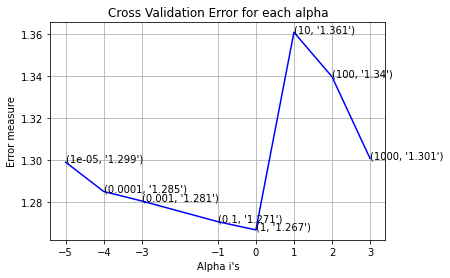

For values of best alpha =  1 The train log loss is: 0.9139558908385376
For values of best alpha =  1 The cross validation log loss is: 1.266812734655761
For values of best alpha =  1 The test log loss is: 1.3178823261105708


In [82]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_error = []
for i in alpha:
    print('for alpha =', i)
    clf = MultinomialNB(alpha = i)
    clf.fit(train_x_onehot, Y_train.values.ravel())
    sif_clf = CalibratedClassifierCV(clf, method = 'sigmoid', cv = 5)
    sif_clf.fit(train_x_onehot, Y_train.values.ravel())
    sig_clf_prbs = sif_clf.predict_proba(cv_x_onehot)
    cv_error.append(log_loss(Y_cv, sig_clf_prbs, labels = clf.classes_, eps = 1e-15))
    print('Log loss :', log_loss(Y_cv, sig_clf_prbs))
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_error,c='b')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_error[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_error)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehot, Y_train.values.ravel())
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv = 5)
sig_clf.fit(train_x_onehot, Y_train.values.ravel())

predict_y = sig_clf.predict_proba(train_x_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))



Number of misclassified points  36.72316384180791
================================================== Confusion matrix ==================================================


c:\users\srini\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


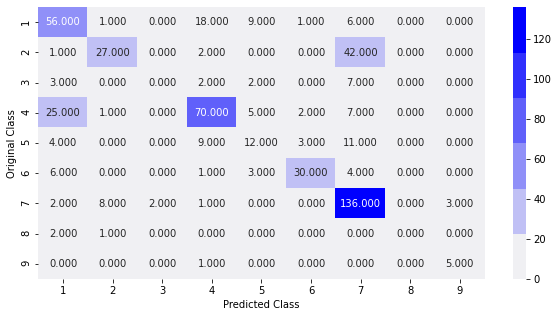

-------------------------------------------------- Precision matrix --------------------------------------------------


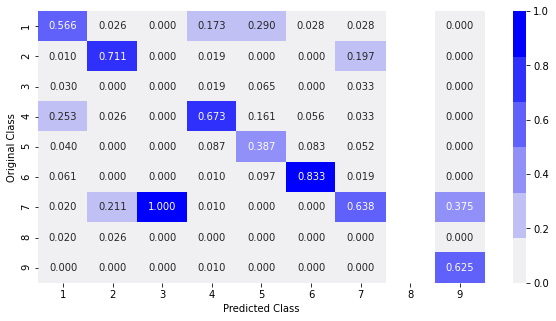

Sum of columns in precision matrix [ 1.  1.  1.  1.  1.  1.  1. nan  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


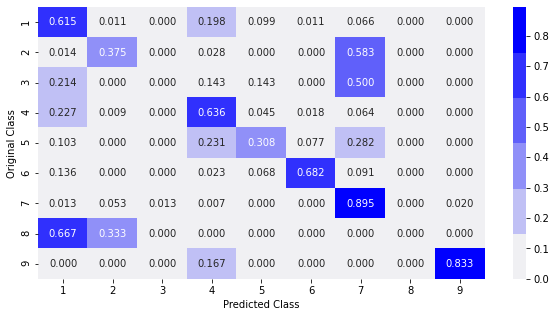

Sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [83]:
predict_y_cls = sig_clf.predict(cv_x_onehot)
plot_confusion_matrix(Y_cv.to_numpy(), predict_y_cls)

Feature importance

In [85]:
test_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehot.tocsr()[test_index])
print('predicted class :', predicted_cls)
print('Actual Class :', Y_cv[1][test_index])
print('Predicted probabilities: ', sig_clf.predict_proba(test_x_onehot.tocsr()[test_index]))
#indices = np.argsort(clf.coef_)[predicted_cls - 1][:,:no_feature]
#get_imp_features(indices[0], X_test['Gene'].iloc[test_index], X_test['Variation'].iloc[test_index], X_test['Text'].iloc[test_index], gene_vectorizer, variation_vectorizer, text_vectorizer)

predicted class : ['7']
Actual Class : 4
Predicted probabilities:  [[0.0748967  0.16181248 0.02624091 0.09814805 0.04941025 0.04816665
  0.52808395 0.0073643  0.0058767 ]]


# KNN

for alpha =  3
Log Loss : 2.106874730198874
for alpha =  5
Log Loss : 1.9758039914350443
for alpha =  11
Log Loss : 1.6606363803397497
for alpha =  15
Log Loss : 1.5447876019002686
for alpha =  21
Log Loss : 1.4852812412533067
for alpha =  31
Log Loss : 1.3613862875665057
for alpha =  41
Log Loss : 1.282888570859474
for alpha =  51
Log Loss : 1.2500236419747333
for alpha =  99
Log Loss : 1.1523041204945503
for alpha =  105
Log Loss : 1.1513455163208566


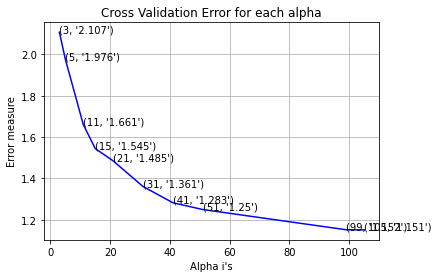

For values of best alpha =  105 The train log loss is: 0.9120206821203077
For values of best alpha =  105 The cross validation log loss is: 1.1513455163208566
For values of best alpha =  105 The test log loss is: 1.1989183230187386


In [86]:
k = [3, 5, 11, 15, 21, 31, 41, 51, 99, 105]
cv_error = []
for i in k:
    print('for alpha = ',i)
    clf = KNeighborsClassifier(n_neighbors = i)
    clf.fit(train_x_response, Y_train.values.ravel())
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_x_response, Y_train.values.ravel())
    sig_clf_probs = sig_clf.predict_proba(cv_x_response)
    cv_error.append(log_loss(Y_cv, sig_clf_probs, labels = clf.classes_, eps = 1e-15 ))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs))

fig, ax = plt.subplots()
ax.plot(k, cv_error , c = 'b')
for i, txt in enumerate(np.round(cv_error, 3)):
    ax.annotate((k[i], str(txt)), (k[i], cv_error[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_k = k[np.argmin(cv_error)]
clf = KNeighborsClassifier(n_neighbors = best_k)
clf.fit(train_x_response, Y_train.values.ravel())
sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
sig_clf.fit(train_x_response, Y_train.values.ravel())

predict_y = sig_clf.predict_proba(train_x_response)
print('For values of best alpha = ', best_k, "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_response)
print('For values of best alpha = ', best_k, "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_response)
print('For values of best alpha = ', best_k, "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))



Number of misclassified points  41.431261770244824
================================================== Confusion matrix ==================================================


c:\users\srini\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


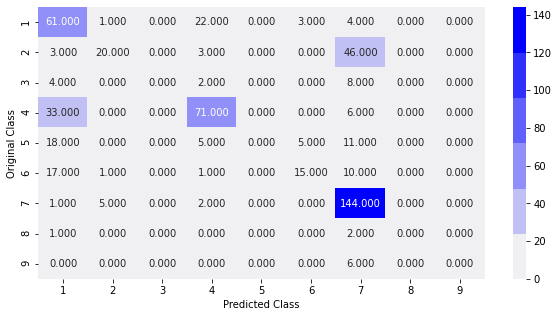

-------------------------------------------------- Precision matrix --------------------------------------------------


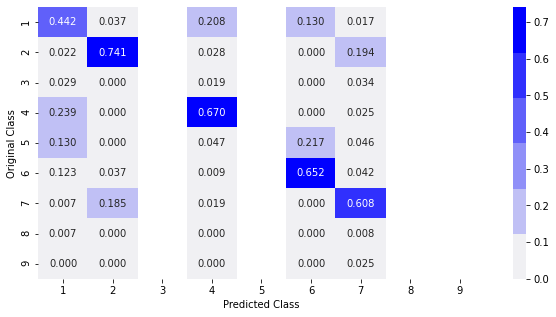

Sum of columns in precision matrix [ 1.  1. nan  1. nan  1.  1. nan nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


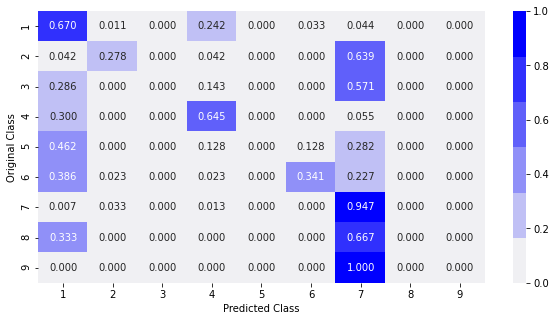

Sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [87]:
predict_y_cls = clf.predict(cv_x_response)
plot_confusion_matrix(Y_cv.to_numpy(), predict_y_cls)

# Logistic Regression

for alpha = 1e-06
Log loss : 1.3042757179304567
for alpha = 1e-05
Log loss : 1.264292980349568
for alpha = 0.0001
Log loss : 1.096868783665931
for alpha = 0.001
Log loss : 1.1009484087533392
for alpha = 0.01
Log loss : 1.1938783280696437
for alpha = 0.1
Log loss : 1.4256071775459078
for alpha = 1
Log loss : 1.6569755299891953
for alpha = 10
Log loss : 1.691232263848505
for alpha = 100
Log loss : 1.6948629123371461


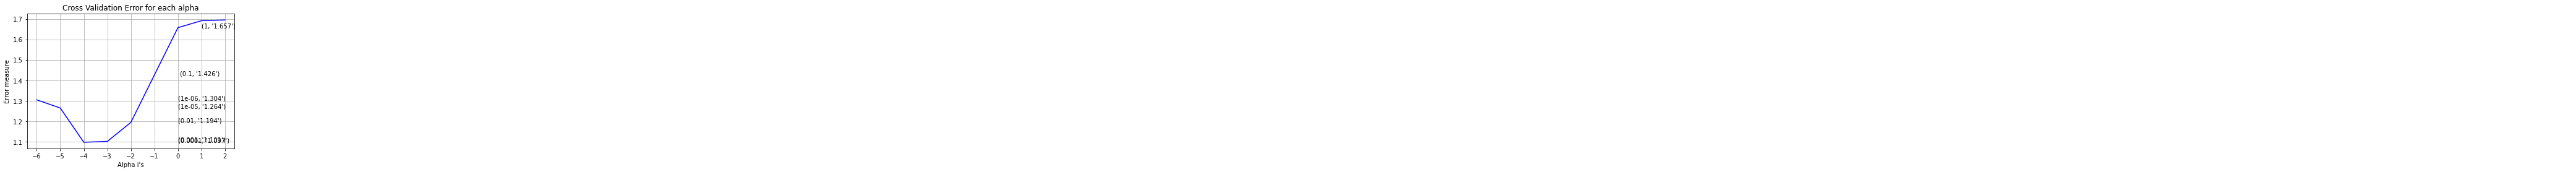

For values of best alpha =  0.0001 The train log loss is: 0.49838158551591355
For values of best alpha =  0.0001 The cross validation log loss is: 1.096868783665931
For values of best alpha =  0.0001 The test log loss is: 1.1059507961943387


In [88]:
alpha = [10**x for x in range(-6,3)]
cv_error = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight = 'balanced', alpha = i, penalty = 'l2', loss = 'log', random_state = 52)
    clf.fit(train_x_onehot, Y_train.values.ravel())
    sif_clf = CalibratedClassifierCV(clf, method = 'sigmoid', cv = 5)
    sif_clf.fit(train_x_onehot, Y_train.values.ravel())
    sig_clf_prbs = sif_clf.predict_proba(cv_x_onehot)
    cv_error.append(log_loss(Y_cv, sig_clf_prbs, labels = clf.classes_, eps = 1e-15))
    print('Log loss :', log_loss(Y_cv, sig_clf_prbs))

    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_error,c='b')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_error[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_error)
clf = SGDClassifier(class_weight = 'balanced', alpha = alpha[best_alpha], penalty = 'l2', loss = 'log', random_state = 52)
clf.fit(train_x_onehot, Y_train.values.ravel())
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv = 5)
sig_clf.fit(train_x_onehot, Y_train.values.ravel())

predict_y = sig_clf.predict_proba(train_x_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))



Number of misclassified points  36.91148775894539
================================================== Confusion matrix ==================================================


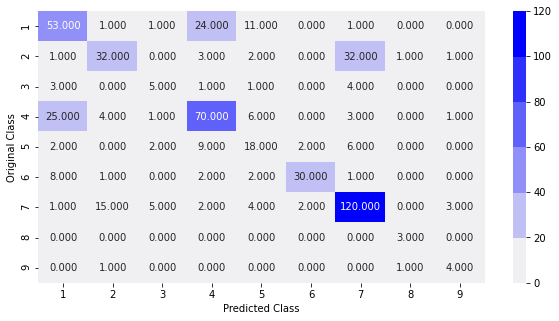

-------------------------------------------------- Precision matrix --------------------------------------------------


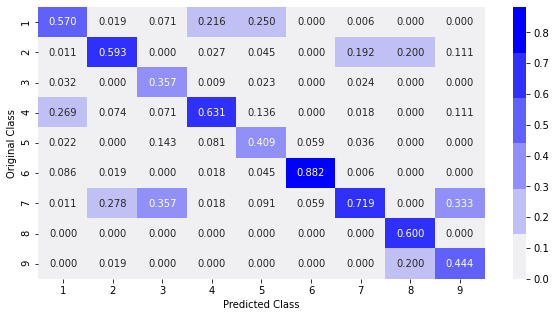

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


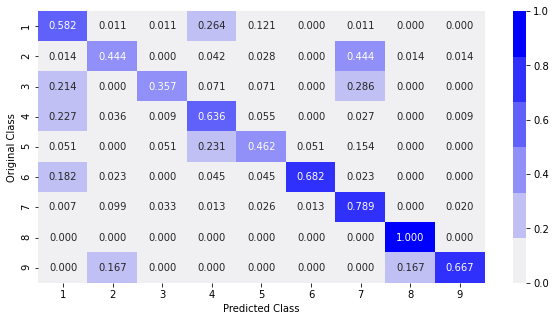

Sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [89]:
predict_y_cls = clf.predict(cv_x_onehot)
plot_confusion_matrix(Y_cv.to_numpy(), predict_y_cls)

# Logistic regression without class balancing

for alpha = 1e-06
Log loss : 1.3160648274100566
for alpha = 1e-05
Log loss : 1.2790912847666194
for alpha = 0.0001
Log loss : 1.1322978866466094
for alpha = 0.001
Log loss : 1.1009669207864117
for alpha = 0.01
Log loss : 1.193688180547388
for alpha = 0.1
Log loss : 1.3419595102709463
for alpha = 1
Log loss : 1.5708049021511803
for alpha = 10
Log loss : 1.6113607037176774
for alpha = 100
Log loss : 1.615945795340053


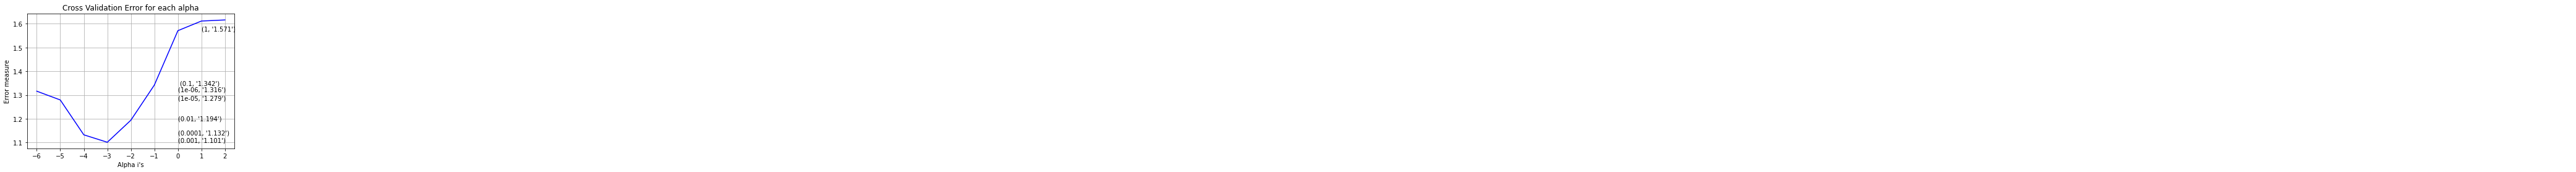

For values of best alpha =  0.001 The train log loss is: 0.5288450478125822
For values of best alpha =  0.001 The cross validation log loss is: 1.1009484087533392
For values of best alpha =  0.001 The test log loss is: 1.0889815515418322


In [90]:
alpha = [10**x for x in range(-6,3)]
cv_error = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha = i, penalty = 'l2', loss = 'log', random_state = 52)
    clf.fit(train_x_onehot, Y_train.values.ravel())
    sif_clf = CalibratedClassifierCV(clf, method = 'sigmoid', cv = 5)
    sif_clf.fit(train_x_onehot, Y_train.values.ravel())
    sig_clf_prbs = sif_clf.predict_proba(cv_x_onehot)
    cv_error.append(log_loss(Y_cv, sig_clf_prbs, labels = clf.classes_, eps = 1e-15))
    print('Log loss :', log_loss(Y_cv, sig_clf_prbs))

    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_error,c='b')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_error[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_error)
clf = SGDClassifier(class_weight = 'balanced', alpha = alpha[best_alpha], penalty = 'l2', loss = 'log', random_state = 52)
clf.fit(train_x_onehot, Y_train.values.ravel())
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv = 5)
sig_clf.fit(train_x_onehot, Y_train.values.ravel())

predict_y = sig_clf.predict_proba(train_x_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))



Number of misclassified points  36.91148775894539
================================================== Confusion matrix ==================================================


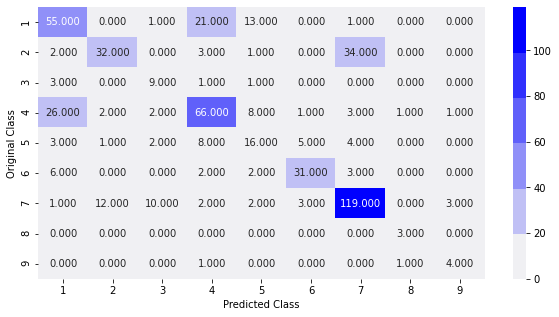

-------------------------------------------------- Precision matrix --------------------------------------------------


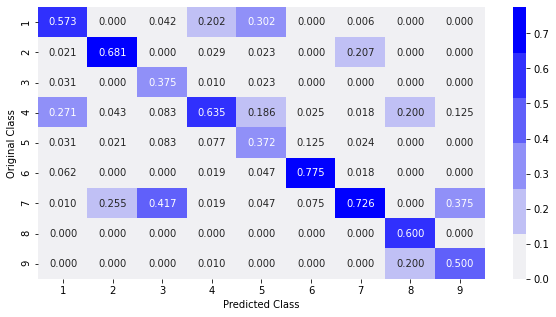

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


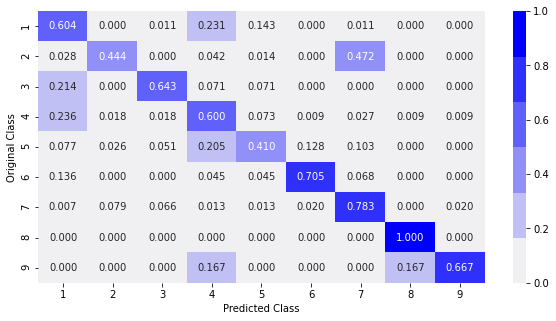

Sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [91]:
predict_y_cls = clf.predict(cv_x_onehot)
plot_confusion_matrix(Y_cv.to_numpy(), predict_y_cls)

# Linear SVM

for alpha = 1e-06
Log loss : 1.297631230302153
for alpha = 1e-05
Log loss : 1.251185038236662
for alpha = 0.0001
Log loss : 1.1939678864110044
for alpha = 0.001
Log loss : 1.1190459481490542
for alpha = 0.01
Log loss : 1.165043089031782
for alpha = 0.1
Log loss : 1.3741111321755282
for alpha = 1
Log loss : 1.6807189567673564
for alpha = 10
Log loss : 1.6954607098211134
for alpha = 100
Log loss : 1.695460695204189


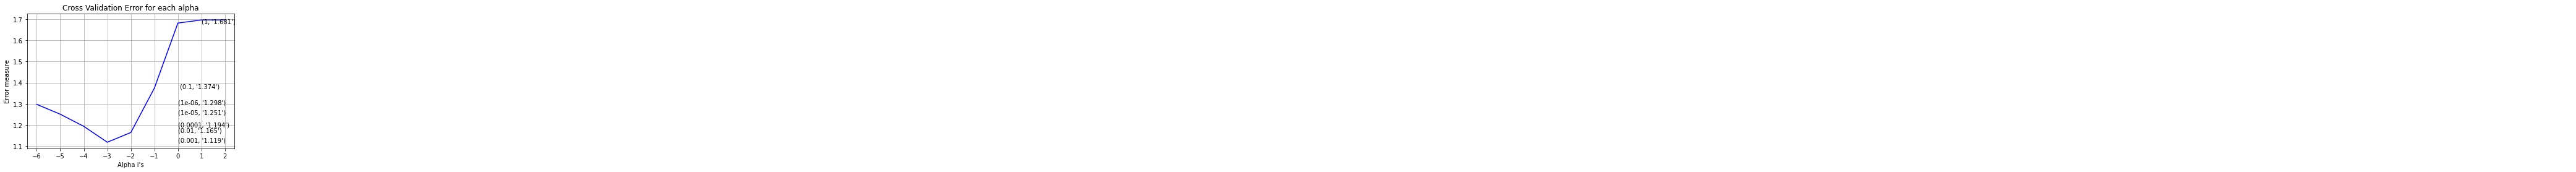

For values of best alpha =  0.001 The train log loss is: 0.5288450478125822
For values of best alpha =  0.001 The cross validation log loss is: 1.1009484087533392
For values of best alpha =  0.001 The test log loss is: 1.0889815515418322


In [92]:
alpha = [10**x for x in range(-6,3)]
cv_error = []
for i in alpha:
    print("for alpha =", i)
    #     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier(class_weight = 'balanced', alpha = i, penalty = 'l2', loss = 'hinge', random_state = 52)
    clf.fit(train_x_onehot, Y_train.values.ravel())
    sif_clf = CalibratedClassifierCV(clf, method = 'sigmoid', cv = 5)
    sif_clf.fit(train_x_onehot, Y_train.values.ravel())
    sig_clf_prbs = sif_clf.predict_proba(cv_x_onehot)
    cv_error.append(log_loss(Y_cv, sig_clf_prbs, labels = clf.classes_, eps = 1e-15))
    print('Log loss :', log_loss(Y_cv, sig_clf_prbs))

    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_error,c='b')
for i, txt in enumerate(np.round(cv_error,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_error[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_error)
clf = SGDClassifier(class_weight = 'balanced', alpha = alpha[best_alpha], penalty = 'l2', loss = 'log', random_state = 52)
clf.fit(train_x_onehot, Y_train.values.ravel())
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv = 5)
sig_clf.fit(train_x_onehot, Y_train.values.ravel())

predict_y = sig_clf.predict_proba(train_x_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehot)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))



Number of misclassified points  36.91148775894539
================================================== Confusion matrix ==================================================


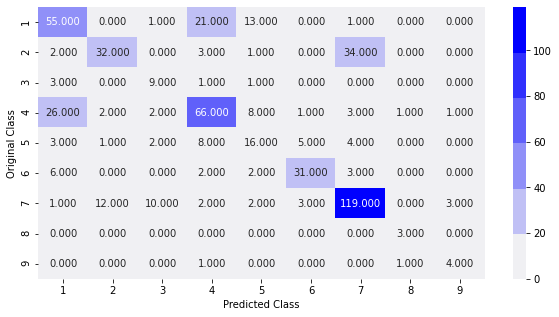

-------------------------------------------------- Precision matrix --------------------------------------------------


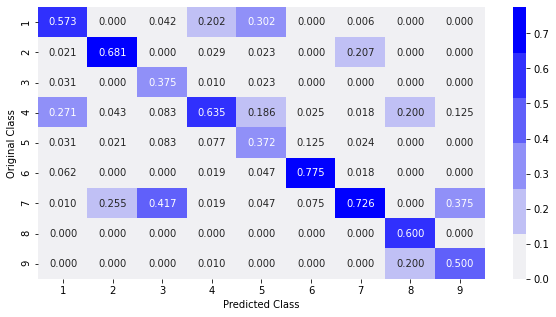

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


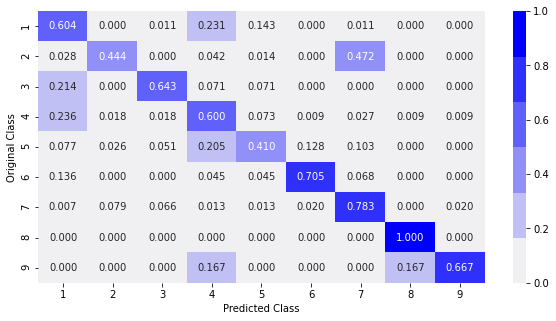

Sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [93]:
predict_y_cls = clf.predict(cv_x_onehot)
plot_confusion_matrix(Y_cv.to_numpy(), predict_y_cls)

# random forests

In [94]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_error = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehot, Y_train.values.ravel())
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehot, Y_train.values.ravel())
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehot)
        cv_error.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(Y_cv, sig_clf_probs))
best_alpha = np.argmin(cv_error)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehot, Y_train.values.ravel())
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehot, Y_train.values.ravel())

predict_y = sig_clf.predict_proba(train_x_onehot)
print('For values of best alpha = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehot)
print('For values of best alpha = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehot)
print('For values of best alpha = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))



for n_estimators = 100 and max depth =  5
Log Loss : 1.21878931611199
for n_estimators = 100 and max depth =  10
Log Loss : 1.1434600998908817
for n_estimators = 200 and max depth =  5
Log Loss : 1.2118691572542002
for n_estimators = 200 and max depth =  10
Log Loss : 1.1378832417574298
for n_estimators = 500 and max depth =  5
Log Loss : 1.207012959355859
for n_estimators = 500 and max depth =  10
Log Loss : 1.1333389422350086
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2048180941134006
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1306043780196817
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2035039691837308
for n_estimators = 2000 and max depth =  10
Log Loss : 1.130370461252165
For values of best alpha =  2000 The train log loss is: 0.6789279750083225
For values of best alpha =  2000 The cross validation log loss is: 1.130370461252165
For values of best alpha =  2000 The test log loss is: 1.1770933955825718


Number of misclassified points  43.50282485875706
================================================== Confusion matrix ==================================================


c:\users\srini\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


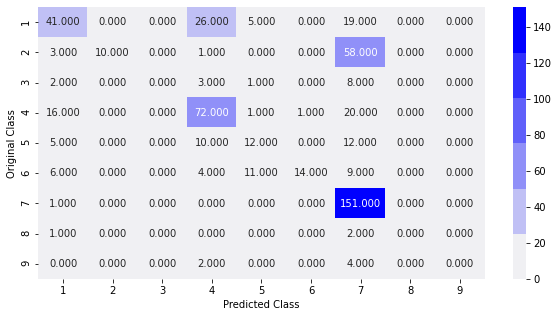

-------------------------------------------------- Precision matrix --------------------------------------------------


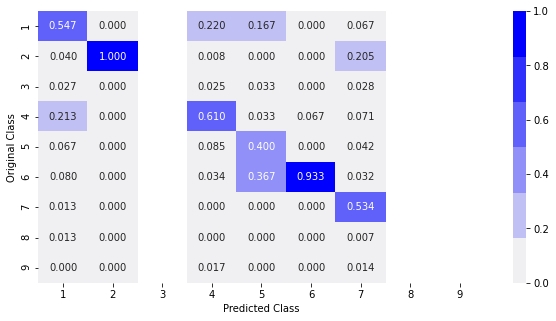

Sum of columns in precision matrix [ 1.  1. nan  1.  1.  1.  1. nan nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


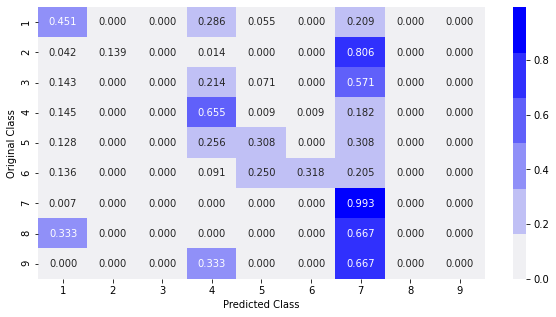

Sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [95]:
predict_y_cls = clf.predict(cv_x_onehot)
plot_confusion_matrix(Y_cv.to_numpy(), predict_y_cls)

In [96]:
alpha = [10,50,100,200,500,1000,2000]
max_depth = [2,3,5,10]
cv_error = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_response, Y_train.values.ravel())
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_response, Y_train.values.ravel())
        sig_clf_probs = sig_clf.predict_proba(cv_x_response)
        cv_error.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(Y_cv, sig_clf_probs))
best_alpha = np.argmin(cv_error)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_response, Y_train.values.ravel())
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_response, Y_train.values.ravel())

predict_y = sig_clf.predict_proba(train_x_response)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_response)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_response)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))



for n_estimators = 10 and max depth =  2
Log Loss : 2.4417771741943968
for n_estimators = 10 and max depth =  3
Log Loss : 2.0444332503304996
for n_estimators = 10 and max depth =  5
Log Loss : 1.9139260447669952
for n_estimators = 10 and max depth =  10
Log Loss : 1.9099291313357547
for n_estimators = 50 and max depth =  2
Log Loss : 1.8102622071017944
for n_estimators = 50 and max depth =  3
Log Loss : 1.5854330751561603
for n_estimators = 50 and max depth =  5
Log Loss : 1.4656788649283718
for n_estimators = 50 and max depth =  10
Log Loss : 1.8690010035294151
for n_estimators = 100 and max depth =  2
Log Loss : 1.595108498829645
for n_estimators = 100 and max depth =  3
Log Loss : 1.509787761488852
for n_estimators = 100 and max depth =  5
Log Loss : 1.395842767076914
for n_estimators = 100 and max depth =  10
Log Loss : 1.838912298110709
for n_estimators = 200 and max depth =  2
Log Loss : 1.6512949037757074
for n_estimators = 200 and max depth =  3
Log Loss : 1.5081541832308416
f

Number of misclassified points  41.99623352165725
================================================== Confusion matrix ==================================================


c:\users\srini\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


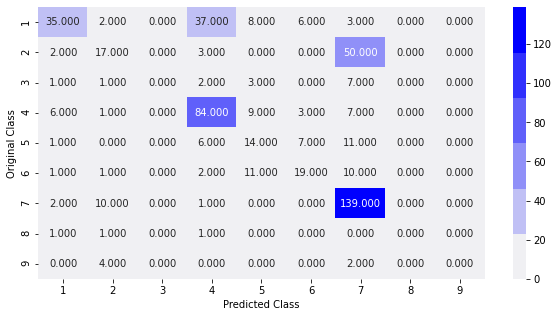

-------------------------------------------------- Precision matrix --------------------------------------------------


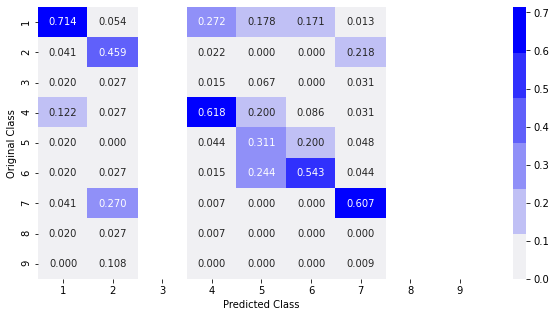

Sum of columns in precision matrix [ 1.  1. nan  1.  1.  1.  1. nan nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


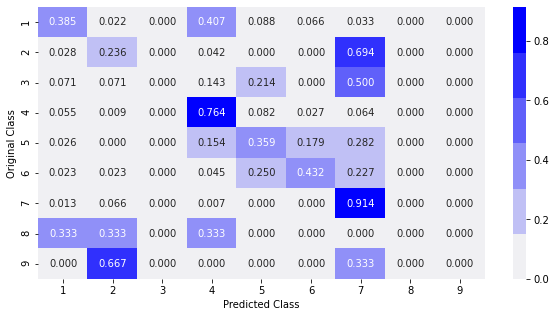

Sum of rows in recall matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [97]:
predict_y_cls = clf.predict(cv_x_response)
plot_confusion_matrix(Y_cv.to_numpy(), predict_y_cls)

In [100]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehot, Y_train.values.ravel())
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=0.001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehot, Y_train.values.ravel())
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=1)
clf3.fit(train_x_onehot, Y_train.values.ravel())
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehot, Y_train.values.ravel())
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(Y_cv, sig_clf1.predict_proba(cv_x_onehot))))
sig_clf2.fit(train_x_onehot, Y_train.values.ravel())
print("Support vector machines : Log Loss: %0.2f" % (log_loss(Y_cv, sig_clf2.predict_proba(cv_x_onehot))))
sig_clf3.fit(train_x_onehot, Y_train.values.ravel())
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(Y_cv, sig_clf3.predict_proba(cv_x_onehot))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
#for i in alpha:
    #lr = LogisticRegression(C=i)
    #sclf = StackingClassifier(estimators=[sig_clf1, sig_clf2, sig_clf3], final_estimator=lr)
    #sclf.fit(train_x_onehot, Y_train.values.ravel())
    #print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(Y_cv, sclf.predict_proba(cv_x_onehot))))
    #log_error =log_loss(Y_cv, sclf.predict_proba(cv_x_onehot))
    #if best_alpha > log_error:
        #best_alpha = log_error

Logistic Regression :  Log Loss: 1.10
Support vector machines : Log Loss: 1.14
Naive Bayes : Log Loss: 1.27
--------------------------------------------------
